# Classify 3-D Lung Tumor Scans Based on Persistence Images
This will pick up where '3D_complex_generator.ipynb' left off by creating persistence images and running classifiers on them

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import gudhi as gd
import pandas as pd
import PersistenceImages.persistence_images as pimg

### Start by loading in the persistent homology data

In [3]:
rad_phom_0s = np.load('./Radiomics_Homology/rad_phom_0s.npy', allow_pickle = True)
rad_phom_1s = np.load('./Radiomics_Homology/rad_phom_1s.npy', allow_pickle = True)
rad_phom_2s = np.load('./Radiomics_Homology/rad_phom_2s.npy', allow_pickle = True)

radg_phom_0s = np.load('./Radiogenomics_Homology/radg_phom_0s.npy', allow_pickle = True)
radg_phom_1s = np.load('./Radiogenomics_Homology/radg_phom_1s.npy', allow_pickle = True)
radg_phom_2s = np.load('./Radiogenomics_Homology/radg_phom_1s.npy', allow_pickle = True)

### Set up persistence image parameters. 

In [4]:
pers_imager = pimg.PersistenceImager()
pers_imager.pixel_size = 0.05
pers_imager.birth_range = (0,1)
pers_imager.pers_range = (0,1)
pers_imager.kernel_params['sigma'][0] = [0.001, 0]
pers_imager.kernel_params['sigma'][1] = [0, 0.001]


print(pers_imager.kernel_params['sigma'][0])
print(pers_imager)

[0.001 0.   ]
PersistenceImager object: 
  pixel size: 0.05 
  resolution: (20, 20) 
  birth range: (0, 1) 
  persistence range: (0, 1) 
  weight: linear_ramp 
  kernel: bvncdf 
  weight parameters: {} 
  kernel parameters: {sigma: [[0.001 0.   ]
 [0.    0.001]]}


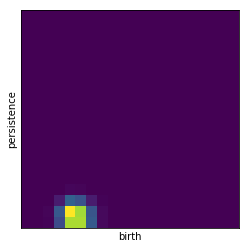

In [5]:
pers_imager.plot_image(rad_phom_0s[190], skew = True)

### Create persistence images from all tumor scans and concatenate arrays

In [6]:
def HomologyToImageVector(phom_0, phom_1, phom_2, imager):
    
    pers_img_0 = imager.transform(phom_0, skew=True)
    pers_img_1 = imager.transform(phom_1, skew=True)
    if len(phom_2) == 0: #Lung 192 is why we can't have nice things
        pers_img_2 = np.zeros_like(pers_img_1)
    else:
        pers_img_2 = imager.transform(phom_2, skew=True)
    
    pers_img_0 = np.resize(pers_img_0, (1, len(pers_img_0)**2))
    pers_img_1 = np.resize(pers_img_1, (1, len(pers_img_1)**2))
    pers_img_2 = np.resize(pers_img_2, (1, len(pers_img_2)**2))
    
    
    
    return(pers_img_0, pers_img_1, pers_img_2)

In [7]:
#Radiomics Dataset

rad_concatenated_images = []

for i in range(len(rad_phom_0s)):
    pimg_0, pimg_1, pimg_2 = HomologyToImageVector(rad_phom_0s[i],rad_phom_1s[i],rad_phom_2s[i], pers_imager)
    
    
    imgs = np.concatenate((pimg_0[0], pimg_1[0], pimg_2[0]), axis=0)
    rad_concatenated_images.append(imgs)

rad_concatenated_images = np.array(rad_concatenated_images)

In [8]:
#Radiogenomics Dataset

radg_concatenated_images = []

for i in range(len(radg_phom_0s)):
    pimg_0, pimg_1, pimg_2 = HomologyToImageVector(radg_phom_0s[i], radg_phom_1s[i], radg_phom_2s[i], pers_imager)
    
    
    imgs = np.concatenate((pimg_0[0], pimg_1[0], pimg_2[0]), axis=0)
    radg_concatenated_images.append(imgs)

radg_concatenated_images = np.array(radg_concatenated_images)

### Read in clinical data

In [9]:
#Radiomics clinical data
rad_clinical = pd.read_csv("rad_clinic.csv")
rad_clinical = rad_clinical.drop(rad_clinical.index[127]) #Tumor 128 has no segmentation

rad_histology = rad_clinical.Histology

#Radiogenomics clinical data
radg_clinical = pd.read_csv("radg_clinic.csv", skiprows = range(1,50))
radg_clinical = radg_clinical[0:146]
radg_clinical = radg_clinical.drop(radg_clinical.index[[8, 142]]) #9 and 143 have no segmentation

radg_clinical["Histology"] = radg_clinical['Histology'].str.lower()
radg_histology = radg_clinical.Histology

### Combine Datasets

In [10]:
radg_adeno = radg_histology == 'adenocarcinoma'
radg_squamous = radg_histology == 'squamous cell carcinoma'
rad_adeno = rad_histology == 'adenocarcinoma'
rad_squamous = rad_histology == 'squamous cell carcinoma'

radg_histology_adsq = np.array(radg_histology[radg_adeno | radg_squamous])
rad_histology_adsq = np.array(rad_histology[rad_adeno | rad_squamous])


radg_concatenated_images_adsq = radg_concatenated_images[radg_adeno | radg_squamous]
rad_concatenated_images_adsq = rad_concatenated_images[rad_adeno | rad_squamous]


histology_adsq = np.array(list(radg_histology_adsq) + list(rad_histology_adsq))
images_adsq = np.array(list(radg_concatenated_images_adsq) + list(rad_concatenated_images_adsq))

# Classification of tumor types

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from xgboost import XGBClassifier

## XGBoost

### Radiomics Dataset

In [12]:
scores = []
y_pred = []
clf_xgboost = XGBClassifier(scale_pos_weight = 3)
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(rad_concatenated_images_adsq):

    X_train, X_test = rad_concatenated_images_adsq[train_index], rad_concatenated_images_adsq[test_index]
    y_train, y_test = rad_histology_adsq[train_index], rad_histology_adsq[test_index]
    clf_xgboost.fit(X_train, y_train)
    y_pred.append(list(clf_xgboost.predict(X_test)))
    scores.append(clf_xgboost.score(X_test, y_test))
y_pred = [val for sublist in y_pred for val in sublist]

print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(rad_histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 68.99%
[[  3  48]
 [ 15 137]]


### Radiogenomics Dataset

In [13]:
scores = []
y_pred = []

clf_xgboost = XGBClassifier(scale_pos_weight = 3)
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(radg_concatenated_images_adsq):

    X_train, X_test = radg_concatenated_images_adsq[train_index], radg_concatenated_images_adsq[test_index]
    y_train, y_test = radg_histology_adsq[train_index], radg_histology_adsq[test_index]
    clf_xgboost.fit(X_train, y_train)
    y_pred.append(list(clf_xgboost.predict(X_test)))
    scores.append(clf_xgboost.score(X_test, y_test))
y_pred = [val for sublist in y_pred for val in sublist]

print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(radg_histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 72.39%
[[97 15]
 [24  5]]


### Combined Dataset

In [14]:
#First we need to shuffle this dataset since otherwise k-fold will magnify batch effects.
images_adsq, histology_adsq = shuffle(images_adsq, histology_adsq, random_state = 0)

scores = []
y_pred = []
clf_xgboost = XGBClassifier()
cv = KFold(n_splits=5, random_state=42, shuffle=False)
for train_index, test_index in cv.split(images_adsq):

    X_train, X_test = images_adsq[train_index], images_adsq[test_index]
    y_train, y_test = histology_adsq[train_index], histology_adsq[test_index]
    clf_xgboost.fit(X_train, y_train)
    y_pred.append(list(clf_xgboost.predict(X_test)))
    scores.append(clf_xgboost.score(X_test, y_test))
    
y_pred = [val for sublist in y_pred for val in sublist]    
print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 69.21%
[[109  54]
 [ 52 129]]


## L1-penalized Logistic Regression on Combined Dataset 

In [15]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [16]:
#First we need to shuffle this dataset since otherwise k-fold will magnify batch effects.
images_adsq, histology_adsq = shuffle(images_adsq, histology_adsq, random_state = 0)

scores = []
y_pred = []


clf_logreg = LogisticRegression(penalty = 'l1', solver='liblinear')


cv = KFold(n_splits=5, random_state=123, shuffle=False)
for train_index, test_index in cv.split(images_adsq):

    X_train, X_test = images_adsq[train_index], images_adsq[test_index]
    y_train, y_test = histology_adsq[train_index], histology_adsq[test_index]
    clf_logreg.fit(X_train, y_train)
    y_pred.append(list(clf_logreg.predict(X_test)))
    scores.append(clf_logreg.score(X_test, y_test))
    
y_pred = [val for sublist in y_pred for val in sublist]    

print("5-fold cross-validated accuracy: %.2f%%" % (np.mean(scores) * 100.0))
print(confusion_matrix(histology_adsq, y_pred, labels=['adenocarcinoma', 'squamous cell carcinoma']))

5-fold cross-validated accuracy: 68.01%
[[105  58]
 [ 52 129]]
